In [2]:
import pandas as pd

from tfidf import TfidfResearch
from bm25 import BM25Research
from faiss_index import FaissResearch
from qdrant_index import QdrantResearch

from sqlalchemy import text
from utils import engine
from tqdm.autonotebook import tqdm

from eval import evaluate
import numpy as np
from utils import clean_text, STOP_RU

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_queries_gt(df: pd.DataFrame) -> tuple[dict[str, list[str]], list[str]]:
    """
    Возвращает:
      • q_gt: словарь query → [article_id, ...]
      • all_ids: список уникальных article_id (строкового типа)
    """
    
    q_gt: dict[str, list[str]] = {}
    for _, row in df.iterrows():
        q = row["query"]
        art_id = str(row["article_id"])
        q_gt.setdefault(q, []).append(art_id)

    all_ids = df["article_id"].astype(str).unique().tolist()
    return q_gt, all_ids

def queries_by_diff(df: pd.DataFrame) -> dict[str, dict[str, list[str]]]:
    """
    Строит словари query→[article_id] отдельно для easy/medium/hard и для всех одновременно.
    Ожидает на вход именно DataFrame с колонками ["query", "article_id", "difficulty"].
    """
    groups: dict[str, dict[str, list[str]]] = {}
    for diff in ("easy", "medium", "hard"):
        sub = df[df["difficulty"] == diff]
        qgt = {q: [str(doc)] for q, doc in zip(sub["query"], sub["article_id"])}
        groups[diff] = qgt

    # общий набор для всех трудностей
    groups["all"] = {q: [str(doc)] for q, doc in zip(df["query"], df["article_id"])}
    return groups

In [4]:
csv_path = "synthetic_queries_random_10000.csv"

# 1) Считаем DataFrame
df_synth = pd.read_csv(csv_path)[:3000]

# 2) Отдельно строим словарь q_gt и all_ids
queries_gt, article_ids = load_queries_gt(df_synth)

# 3) А для групп по сложности нужно передать в функцию сам DataFrame:
q_groups = queries_by_diff(df_synth)

print(f"Total requests: {len(queries_gt)}, Documents in corpus: {len(article_ids)}")
print(f"Groups keys: {list(q_groups.keys())}")  # easy, medium, hard, all

Total requests: 2974, Documents in corpus: 1000
Groups keys: ['easy', 'medium', 'hard', 'all']


In [5]:
sql = text("""
    SELECT id::text,
           COALESCE(title, '')   AS title,
           COALESCE(anons, '')   AS anons,
           COALESCE(body, '')    AS body
      FROM public.tmp_news
     WHERE id = ANY(:ids);
""")

df_docs = pd.read_sql(sql, engine, params={"ids": article_ids})


df_docs["full_text"] = (
    df_docs["title"] + ". " +
    df_docs["anons"] + ". " +
    df_docs["body"]
)
texts = df_docs["full_text"].tolist()
ids   = df_docs["id"].tolist()

print("News example:", texts[0][:150], "…")

News example: В Таиланде две туристки погибли в упавшей со второго этажа паркинга машине. Две жительницы Таиланда погибли, и еще одна получила ранения, после того к …


Base Experiments

In [12]:
tfidf_backend = TfidfResearch(max_features=30_000)
tfidf_backend.index(tqdm(texts), ids)

metrics_by_level = {
    lvl: evaluate(tfidf_backend, qgt, top_k=10, max_workers=20)
    for lvl, qgt in tqdm(q_groups.items())
}

metrics_by_level

100%|██████████| 1000/1000 [00:00<00:00, 12464.72it/s]


 50%|█████     | 2/4 [00:03<00:03,  1.97s/it]

[Error] query=nan → AttributeError: 'float' object has no attribute 'lower'


 75%|███████▌  | 3/4 [00:05<00:01,  1.99s/it]

[Error] query=nan → AttributeError: 'float' object has no attribute 'lower'


100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


{'easy': {'Precision@10': 0.09848178137651822,
  'Recall@10': 0.9848178137651822,
  'MRR': 0.964120638133796},
 'medium': {'Precision@10': 0.09627766599597587,
  'Recall@10': 0.9627766599597586,
  'MRR': 0.9038596659321005},
 'hard': {'Precision@10': 0.0933467741935484,
  'Recall@10': 0.9334677419354839,
  'MRR': 0.8319164426523298},
 'all': {'Precision@10': 0.09603227975790181,
  'Recall@10': 0.9603227975790182,
  'MRR': 0.8998819130880328}}

In [13]:
bm25_backend = BM25Research()
bm25_backend.index(texts, ids)

metrics_by_level = {
    lvl: evaluate(bm25_backend, qgt, top_k=10)
    for lvl, qgt in tqdm(q_groups.items())
}

metrics_by_level

 50%|█████     | 2/4 [00:04<00:05,  2.53s/it]

[Error] query=nan → AttributeError: 'float' object has no attribute 'lower'


 75%|███████▌  | 3/4 [00:07<00:02,  2.68s/it]

[Error] query=nan → AttributeError: 'float' object has no attribute 'lower'


100%|██████████| 4/4 [00:15<00:00,  3.88s/it]


{'easy': {'Precision@10': 0.0986842105263158,
  'Recall@10': 0.9868421052631579,
  'MRR': 0.9734143049932523},
 'medium': {'Precision@10': 0.09657947686116701,
  'Recall@10': 0.96579476861167,
  'MRR': 0.9204432946887675},
 'hard': {'Precision@10': 0.09435483870967742,
  'Recall@10': 0.9435483870967742,
  'MRR': 0.8698680715565795},
 'all': {'Precision@10': 0.09653665097511767,
  'Recall@10': 0.9653665097511769,
  'MRR': 0.9211711819899446}}

In [ ]:
faiss_frida = FaissResearch(model_name="sergeyzh/BERTA", embed_dim=768)
faiss_frida.index(tqdm(texts), ids)

metrics_by_level = {
    lvl: evaluate(faiss_frida, qgt, top_k=10, max_workers=20)
    for lvl, qgt in tqdm(q_groups.items())
}

metrics_by_level

100%|██████████| 1000/1000 [00:00<00:00, 10650.12it/s]


StopIteration: 

In [55]:
qdrant_backend = QdrantResearch(
    collection_name="news_research_synth",
    model_name="sergeyzh/BERTA",
    embed_dim=768,
)
qdrant_backend.index(texts, ids)

metrics_by_level = {
    lvl: evaluate(qdrant_backend, qgt, top_k=10)
    for lvl, qgt in q_groups.items()
}

metrics_by_level

{'easy': {'Precision@10': 0.09897959183673469,
  'Recall@10': 0.9897959183673469,
  'MRR': 0.9447278911564627},
 'medium': {'Precision@10': 0.09898989898989898,
  'Recall@10': 0.98989898989899,
  'MRR': 0.9562289562289563},
 'hard': {'Precision@10': 0.09899999999999999,
  'Recall@10': 0.99,
  'MRR': 0.9683333333333333},
 'all': {'Precision@10': 0.09898989898989899,
  'Recall@10': 0.98989898989899,
  'MRR': 0.9565095398428731}}

*Additional experiments*

Lemmatise

In [34]:
import inspect
if not hasattr(inspect, "getargspec"):
    inspect.getargspec = inspect.getfullargspec      # <-- добавляем

# теперь можно спокойно импортировать MorphAnalyzer
from pymorphy2 import MorphAnalyzer
import nltk, re
nltk.download("punkt", quiet=True)

morph = MorphAnalyzer()

def lemmatize_text(txt: str) -> str:
    tokens = [tok for tok in nltk.word_tokenize(txt.lower()) if tok.isalpha()]
    lemmas = [
        morph.parse(tok)[0].normal_form
        for tok in tokens
        if len(tok) > 2
    ]
    return " ".join(lemmas)

# Применяем лемматизацию ко всем текстам (может быть долго, идёт прогресс-баром)
texts_lemma = [lemmatize_text(t) for t in tqdm(texts, desc="pymorphy lemmatize")]
queries_gt_lemma: dict[str, list[str]] = {}

for q, ids_list in tqdm(queries_gt.items(), desc="lemmatize queries"):
    lem_q = lemmatize_text(q)                  # ← ваша функция из шага 5.1
    # объединяем id, если лемматизированный ключ уже встречался
    queries_gt_lemma.setdefault(lem_q, []).extend(ids_list)

# (необязательно) уберём дубликаты id в каждом списке
for k in queries_gt_lemma:
    queries_gt_lemma[k] = list(set(queries_gt_lemma[k]))

pymorphy lemmatize:   0%|          | 0/100 [00:00<?, ?it/s]

lemmatize queries: 100%|██████████| 297/297 [00:00<00:00, 1220.65it/s]


In [35]:
tfidf_lemma = TfidfResearch(max_features=30_000)
tfidf_lemma.index(texts_lemma, ids)
metrics_tfidf_lemma = evaluate(tfidf_lemma, queries_gt_lemma, top_k=10)
print("TF-IDF + Pymorphy:", metrics_tfidf_lemma)

TF-IDF + Pymorphy: {'Precision@10': 0.09797979797979796, 'Recall@10': 0.9696969696969697, 'MRR': 0.9380471380471381}


In [ ]:
bm25_backend = BM25Research()
bm25_backend.index(texts_lemma, ids)
metrics_bm25_lemma = evaluate(bm25_backend, queries_gt_lemma, top_k=10)
print("BM-25 + Pymorphy:", metrics_bm25_lemma)

BM-25 + Natasha-лемматизация: {'Precision@10': 0.09797979797979796, 'Recall@10': 0.9696969696969697, 'MRR': 0.9486531986531986}


In [33]:
faiss_frida = FaissResearch(model_name="sergeyzh/BERTA", embed_dim=768)
faiss_frida.index(texts_lemma, ids)
metrics_bm25_lemma = evaluate(faiss_frida, queries_gt_lemma, top_k=10)
print("FAISS + Pymorphy:", metrics_bm25_lemma)

FAISS + Pymorphy: {'Precision@10': 0.09999999999999999, 'Recall@10': 0.98989898989899, 'MRR': 0.9562289562289562}


Spellchecker

In [35]:
from spellchecker import SpellChecker
spell = SpellChecker(language="ru")

def spell_correct(txt: str) -> str:
    toks  = txt.split()
    fixed = [spell.correction(t) or t for t in toks]
    return " ".join(fixed)


queries_gt_spell = {spell_correct(q): gts for q, gts in tqdm(queries_gt.items())}

bm25_spell = BM25Research()
bm25_spell.index(texts, ids)
metrics_bm25_spell = evaluate(bm25_spell, queries_gt_spell, top_k=10)
print("BM25 + spell-коррекция:", metrics_bm25_spell)


  0%|          | 0/297 [00:00<?, ?it/s]

100%|██████████| 297/297 [04:13<00:00,  1.17it/s]

BM25 + spell-коррекция: {'Precision@10': 0.09528619528619528, 'Recall@10': 0.9427609427609428, 'MRR': 0.8620490620490622}


Hybrid search

In [31]:
faiss_full = FaissResearch(model_name="sergeyzh/BERTA")
faiss_full.index(texts, ids)                 # ← долго, но один раз!
doc_embs      = faiss_full.embeddings        # ndarray shape (N, 768)
id2pos: dict  = {doc_id: i for i, doc_id in enumerate(ids)}


In [32]:
def hybrid_search_fast(query: str, N: int = 100, top_k: int = 10):
    top_tfidf = tfidf_lemma.search(query, top_k=N)
    sub_idx   = np.array([id2pos[d] for d, _ in top_tfidf], dtype=np.int64)

    q_vec = faiss_full._get_embeddings([query])   

    scores = np.squeeze(q_vec @ doc_embs[sub_idx].T)

    order  = np.argsort(scores)[::-1][:top_k]
    result = [(ids[sub_idx[i]], float(scores[i])) for i in order]
    return result


class HybridFastBackend:
    def __init__(self, N=100, top_k=10):
        self.N = N
        self.top_k = top_k
    def index(self, *args, **kwargs):
        pass                               # ничего не нужно — всё уже посчитано
    def search(self, q, top_k=10):
        return hybrid_search_fast(q, N=self.N, top_k=top_k)

In [36]:
hybrid_fast = HybridFastBackend(N=50)

metrics_by_level = {
    lvl: evaluate(hybrid_fast, qgt, top_k=10)
    for lvl, qgt in q_groups.items()
}

metrics_by_level

{'easy': {'Precision@10': 0.09285714285714286,
  'Recall@10': 0.9285714285714286,
  'MRR': 0.9132653061224489},
 'medium': {'Precision@10': 0.0909090909090909,
  'Recall@10': 0.9090909090909091,
  'MRR': 0.9040404040404041},
 'hard': {'Precision@10': 0.08899999999999998,
  'Recall@10': 0.89,
  'MRR': 0.865},
 'all': {'Precision@10': 0.0909090909090909,
  'Recall@10': 0.9090909090909091,
  'MRR': 0.8939393939393939}}

Named entity recognition improvement

In [29]:
# ──────────────────────────────────────────────────────────────
# 1. NER-настройка (Natasha)
# ──────────────────────────────────────────────────────────────
from natasha import Doc, Segmenter, NewsEmbedding, NewsNERTagger
from tqdm.auto import tqdm

segmenter = Segmenter()
emb       = NewsEmbedding()
ner       = NewsNERTagger(emb)

def extract_ents(text: str) -> list[str]:
    """
    Возвращает список строк вида 'LOC:москва', 'ORG:роснефть', ...
    анализируя первые 600 символов текста.
    """
    doc = Doc(text[:600])
    doc.segment(segmenter)
    doc.tag_ner(ner)
    return [f"{s.type}:{s.text.lower()}" for s in doc.spans]


from faiss_index import FaissResearch   # ваш переименованный файл

faiss_full = FaissResearch(model_name="sergeyzh/BERTA")   # или FRIDA, e5 …
faiss_full.index(texts, ids)                              # обычный индекс

# Добавляем словарь {id: [ents]} прямо в объект
faiss_full.id2ents = {
    str(ids[i]): extract_ents(texts[i])
    for i in tqdm(range(len(ids)), desc="NER payload")
}

print("Пример payload:", list(faiss_full.id2ents.items())[:3])


NER payload: 100%|██████████| 100/100 [00:01<00:00, 74.38it/s]

Пример payload: [('bab34614b4129cc31283bce68438232b', ['LOC:новосибирске', 'LOC:новосибирске', 'LOC:дзержинского района', 'LOC:новосибирске', 'LOC:нсо', 'LOC:дзержинского района']), ('fd20e477c9c7d337a3fd5db6e6100321', ['ORG:русской православной церкви', 'LOC:московский', 'PER:кирилл', 'ORG:архиерейского собора', 'ORG:священного синода', 'LOC:московский', 'PER:кирилл', 'ORG:архиерейского собора', 'ORG:священного синода&quot', 'ORG:&quot']), ('a7bd3167d8fff552a622130a59935bc2', ['LOC:германии', 'LOC:германии', 'LOC:аугсбурге', 'LOC:швабия', 'LOC:германии', 'LOC:аугсбурге', 'ORG:тасс'])]


In [30]:
def ner_boost_faiss(query: str, top_k: int = 10, alpha: float = 0.2):
    """
    1) векторный поиск FAISS
    2) + бонус `alpha` за каждую общую сущность запроса и документа
    """
    ents_q = extract_ents(query)
    raw = faiss_full.search(query, top_k=top_k*3)    # берём запас
    scored = []
    for doc_id, base_score in raw:
        overlap = len(set(faiss_full.id2ents.get(doc_id, [])) & set(ents_q))
        scored.append((doc_id, base_score + alpha*overlap))
    scored.sort(key=lambda x: x[1], reverse=True)
    return scored[:top_k]


# ► Проверяем
for q in ["пожар в москве", "встреча с путином"]:
    print("\nQ:", q)
    print("Без boost:", faiss_full.search(q, 5))
    print("NER-boost:", ner_boost_faiss(q, 5))



Q: пожар в москве
Без boost: [('fc8902157d344ae9ddb6602b9a8caaa3', 1.0448417663574219), ('a7a1a0e755c6bdc594d37cdaeecf07cc', 1.0448417663574219), ('15c3f7bc4e8f76ac01ce63cf4ea0f65e', 1.3028838634490967), ('2fb11a24a2cdc69e9c239b1e861ef910', 1.3695847988128662), ('0c292ceb9e63b4b3ed5c6d7be6f43019', 1.4129849672317505)]
NER-boost: [('4a7fd74fcfc97e870e28a3464b155be2', 1.7553651332855225), ('fd20e477c9c7d337a3fd5db6e6100321', 1.7528676986694336), ('51517c3348b0f0a143d5fed13c7ec6f9', 1.7474628686904907), ('5510d8d9947b0badf27989399afc67f8', 1.738696813583374), ('5e990eb7f33144dd29f6fef8b2b0e493', 1.7267558574676514)]

Q: встреча с путином
Без boost: [('fc8902157d344ae9ddb6602b9a8caaa3', 1.0292555093765259), ('a7a1a0e755c6bdc594d37cdaeecf07cc', 1.0292555093765259), ('6440bfae1bbfb1d74e93d600a2070311', 1.2496813535690308), ('d949c94b0099d8292921907dfad59612', 1.2940669059753418), ('aaf6b12185577cc6f2d97bde0e75a238', 1.338442325592041)]
NER-boost: [('b2fc9c914e0c5aa3669a2f093d48d8c7', 1.6160

In [44]:
# ══════════════════════════════════════════════════════════════════════════════
# БЫСТРЫЙ HYBRID-backend: сравниваем «без NER» vs «с NER-boost»
# ══════════════════════════════════════════════════════════════════════════════
# требуются:
# • tfidf_lemma          – уже обученный TF-IDF (на леммах)
# • doc_embs (np.ndarray)– эмбеддинги всех docs,   shape = (len(ids), 768)
# • id2pos               – словарь {doc_id → index в doc_embs}
# • id2ents              – словарь {doc_id → [список сущностей]}  (см. предыдущую ячейку)
# • функции extract_ents  – NER из запроса

import numpy as np
from eval import evaluate

# ───────────────────────────────
# 1. Поиск без NER-бонуса
# ───────────────────────────────
def hybrid_search_fast(query: str, N: int = 100, top_k: int = 10):
    top_tfidf = tfidf_lemma.search(query, top_k=N)
    sub_idx   = np.array([id2pos[d] for d, _ in top_tfidf], dtype=np.int64)

    q_vec  = faiss_full._get_embeddings([query])          # (1,768)
    scores = np.squeeze(q_vec @ doc_embs[sub_idx].T)      # (N,)

    order  = np.argsort(scores)[::-1][:top_k]
    return [(ids[sub_idx[i]], float(scores[i])) for i in order]

class HybridFastBackend:
    def __init__(self, N=100):
        self.N = N
    def index(self, *args, **kwargs):          # не нужен
        pass
    def search(self, q, top_k=10):
        return hybrid_search_fast(q, self.N, top_k)

# ───────────────────────────────
# 2. Поиск с NER-boost
# ───────────────────────────────
def hybrid_search_fast_ner(query: str, N: int = 100, top_k: int = 10,
                           alpha: float = 0.2):
    top_tfidf = tfidf_lemma.search(query, top_k=N)
    sub_idx   = np.array([id2pos[d] for d, _ in top_tfidf], dtype=np.int64)

    q_vec  = faiss_full._get_embeddings([query])
    scores = np.squeeze(q_vec @ doc_embs[sub_idx].T)

    ents_q = set(extract_ents(query))
    # добавляем бонус за пересечение сущностей
    for j, doc_idx in enumerate(sub_idx):
        overlap = len(ents_q & set(faiss_full.id2ents.get(ids[doc_idx], [])))
        scores[j] += alpha * overlap

    order  = np.argsort(scores)[::-1][:top_k]
    return [(ids[sub_idx[i]], float(scores[i])) for i in order]

class HybridFastNERBackend(HybridFastBackend):
    def __init__(self, N=100, alpha=0.2):
        super().__init__(N)
        self.alpha = alpha
    def search(self, q, top_k=10):
        return hybrid_search_fast_ner(q, self.N, top_k, self.alpha)



In [ ]:
hybrid_plain = HybridFastBackend(N=50)
metrics_plain = {
    lvl: evaluate(hybrid_plain, qgt, top_k=10)
    for lvl, qgt in q_groups.items()
}

In [46]:
hybrid_ner   = HybridFastNERBackend(N=50, alpha=0.05)
faiss_full.id2ents = {
    str(ids[i]): extract_ents(texts[i])
    for i in tqdm(range(len(ids)), desc="NER payload")
}
metrics_ner = {
    lvl: evaluate(hybrid_ner, qgt, top_k=10)
    for lvl, qgt in q_groups.items()
}

NER payload: 100%|██████████| 100/100 [00:00<00:00, 109.64it/s]


In [47]:
df_plain = (pd.DataFrame(metrics_plain).T
            .assign(version="plain")
            .reset_index(names="level"))
df_ner   = (pd.DataFrame(metrics_ner).T
            .assign(version="ner_boost")
            .reset_index(names="level"))

df_cmp = pd.concat([df_plain, df_ner])


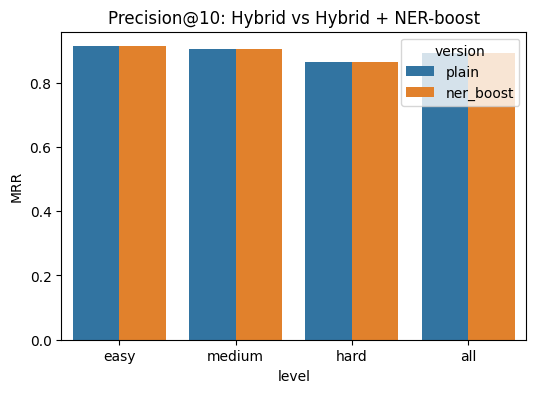

In [48]:
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.barplot(data=df_cmp, x="level", y="MRR", hue="version")
plt.title("Precision@10: Hybrid vs Hybrid + NER-boost")
plt.show()

Topic clustering

In [3]:
faiss_frida = FaissResearch(model_name="sergeyzh/BERTA", embed_dim=768)
faiss_frida.index(texts, ids)

from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE   # для картинки 2-D
import matplotlib.pyplot as plt

emb = faiss_frida.embeddings          # shape (N,768)
kmeans = MiniBatchKMeans(n_clusters=20, batch_size=1024, random_state=42).fit(emb)
df_docs["cluster"] = kmeans.labels_

# ── 2-D-проекция на t-SNE для иллюстрации ──
subset = emb[:2000]                   # чтобы t-SNE не тормозил
tsne2d  = TSNE(n_components=2, perplexity=30, init="pca", random_state=42).fit_transform(subset)
plt.figure(figsize=(6,5))
plt.scatter(tsne2d[:,0], tsne2d[:,1], c=kmeans.labels_[:2000], s=12, cmap="tab20")
plt.title("Тематические кластеры новостей (t-SNE)")
plt.axis("off")
plt.show()

NameError: name 'texts' is not defined